# Notebook 1: Text-to-Image DCGAN for 28x28 MNIST

This tutorial demonstrates how to control the generation of images of handwritten digits with an additional categorical input using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). This is a necessary change compared to the original tutorial as the generator as well as the discriminator require two input layers (e.g. the generator needs one input for the noise and second one for the categorical input). Another difference is that the training dataset will be downloaded from *tf.keras.datasets* to a local directory to already simulate that data is located on your local machine to ease future switch to another dataset.

## Setup
Import required dependencies/packages and define input/output locations.

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.9.1'

Check whether your GPU is correctly set up.
I'm using a NVIDIA RTX 2080 with CUDA 11.2 and cuDNN 8.4.1.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import time
import pickle
from tqdm import tqdm
from PIL import Image

In [5]:
data_dir = "data/mnist"
dataset_dir = f"{data_dir}/dataset"
output_dir = "output/1-text-to-image-dcgan-mnist-28x28"
checkpoint_dir = f"{output_dir}/training_checkpoints"

## Download the dataset from tf.keras.datasets.mnist

The dataset will be downloaded from the original Tensorflow source and saved into the previously specified path.

In [41]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [42]:
os.makedirs(dataset_dir, exist_ok=True)

In [43]:
def to_written_number(nmbr: int) -> str:
    if nmbr == 0:
        return "zero"
    if nmbr == 1:
        return "one"
    if nmbr == 2:
        return "two"
    if nmbr == 3:
        return "three"
    if nmbr == 4:
        return "four"
    if nmbr == 5:
        return "five"
    if nmbr == 6:
        return "six"
    if nmbr == 7:
        return "seven"
    if nmbr == 8:
        return "eight"
    if nmbr == 9:
        return "nine"

In [44]:
labels = []

for idx, image in enumerate(tqdm(x_train)):
    im = Image.fromarray(image)
    im.save(f"{dataset_dir}/{idx}.png")
    l = to_written_number(y_train[idx])
    labels.append(l)

x_train_length = len(x_train)
for idx, image in enumerate(tqdm(x_test)):
    im = Image.fromarray(image)
    im.save(f"{dataset_dir}/{x_train_length+idx}.png")
    l = to_written_number(y_test[idx])
    labels.append(l)

100%|██████████| 10000/10000 [00:11<00:00, 873.95it/s]


In [45]:
with open(f"{data_dir}/labels.pkl", "wb") as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator.

In [11]:
with open(f"{data_dir}/labels.pkl", "rb") as handle:
    labels = pickle.load(handle)

In [12]:
BUFFER_SIZE = len(labels) # 70000
BATCH_SIZE = 256
pixel = 28

In [13]:
images = []
written_numbers = []

for idx, label in enumerate(tqdm(labels)):
    im = Image.open(f"{dataset_dir}/{idx}.png")
    im = imageio.core.util.Array(np.asarray(im))
    im = im.reshape(pixel, pixel, 1).astype('float32')
    im = (im - 127.5) / 127.5  # Normalize the images to [-1, 1]

    images.append(im)
    written_numbers.append(label)

100%|██████████| 70000/70000 [05:30<00:00, 211.54it/s]


Convert the lists to ndarrays.

In [14]:
def convert_to_nparray(name, arr):
    np_array = np.asarray(arr)
    print(f"### {name} ###")
    print(type(np_array))
    print(np_array.shape)
    return np_array

In [15]:
awesome_images = convert_to_nparray("images", images)
awesome_written_numbers = convert_to_nparray("written_numbers", written_numbers)

### images ###
<class 'numpy.ndarray'>
(70000, 28, 28, 1)
### written_numbers ###
<class 'numpy.ndarray'>
(70000,)


In [16]:
awesome_train_dataset = tf.data.Dataset.from_tensor_slices({"image": awesome_images, "written_number": awesome_written_numbers})\
    .shuffle(BUFFER_SIZE)\
    .batch(batch_size=BATCH_SIZE, drop_remainder=True)

## Create the models

Both generator and discriminator are following the layer design described in [Generative Adversarial Text to Image Synthesis](https://arxiv.org/pdf/1605.05396.pdf) just with the difference that we're feeding a categorical feature instead of an embedding vector.

![](docs/Generative_Adversarial_Text_to_Image_Synthesis.png)

In [17]:
noise_dim = 100

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise) and the additional categorical feature (written number). Start with a `Dense` layer that takes the seed and the written number as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [18]:
features = [
    ("written_number", 10)
]

In [19]:
def build_feature_columns(features: dict):
    feature_layer_inputs = {}
    feature_columns = []
    for name, hash_bucket_size in features:
        feature_columns.append(tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_hash_bucket(name, hash_bucket_size=hash_bucket_size)))
        feature_layer_inputs[name] = layers.Input(shape=(), name=name, dtype=tf.string)
    return feature_columns, feature_layer_inputs

In [20]:
def make_generator_model():
    feature_columns, feature_layer_inputs = build_feature_columns(features=features)
    fc_layer = layers.DenseFeatures(feature_columns)
    fc = fc_layer(feature_layer_inputs)

    image_input = layers.Input(shape=(noise_dim,), name='noise')

    x = layers.concatenate([fc, image_input], axis=1)
    x = layers.Dense(7 * 7 * 256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    inputs = list(feature_layer_inputs.values())
    inputs.append(image_input)
    return Model(inputs=inputs, outputs=x, name="generator")

Build the generator model and summarize the structure.

In [21]:
generator = make_generator_model()
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 written_number (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 dense_features (DenseFeatures)  (None, 10)          0           ['written_number[0][0]']         
                                                                                                  
 noise (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 110)          0           ['dense_features[0][0]',         
                                                                  'noise[0][0]']          

Use the (as yet untrained) generator to create an image.

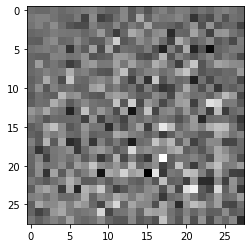

In [22]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator({"noise": noise, "written_number": tf.constant(["zero"])}, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [23]:
def make_discriminator_model():
    image_input = layers.Input(shape=(pixel, pixel, 1), name='image')

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    feature_columns, feature_layer_inputs = build_feature_columns(features=features)
    fc_layer = layers.DenseFeatures(feature_columns)
    fc = fc_layer(feature_layer_inputs)

    x = layers.concatenate([fc, x], axis=1)

    x = layers.Dense(1)(x)

    inputs = list(feature_layer_inputs.values())
    inputs.append(image_input)
    return Model(inputs=inputs, outputs=x, name="discriminator")

Build the generator model and summarize the structure.

In [24]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   1664        ['image[0][0]']                  
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      (None, 14, 14, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 64)   0           ['leaky_re_lu_3[0][0]']          
                                                                                      

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [25]:
decision = discriminator({"image": generated_image, "written_number": tf.constant(["five"])})
print(decision)

tf.Tensor([[0.03021652]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [30]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop
The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [31]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator({"noise": noise, "written_number": batch["written_number"]}, training=True)

      real_output = discriminator({"image": batch["image"], "written_number": batch["written_number"]}, training=True)
      fake_output = discriminator({"image": generated_images, "written_number": batch["written_number"]}, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
def train(dataset, epochs):
  for epoch in range(1, epochs+1):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    show = True if (epoch % VISUALIZE_EVERY_X_EPOCHS) == 0 else False
    generate_and_save_images(generator, test_noise, "{}/image_at_epoch_{:04d}.png".format(output_dir, epoch), show=show)

    if (epoch % CHECKPOINT_EVERY_X_EPOCHS) == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

**Generate and save images**


In [33]:
num_examples_to_generate = 10
test_noise = tf.random.normal([num_examples_to_generate, noise_dim])
test_written_numbers = tf.constant(["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"])

In [34]:
def generate_and_save_images(model, noise, output_path, show, save=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model({"noise": noise, "written_number": test_written_numbers}, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save:
    plt.savefig(output_path)
  if show:
    plt.show()

  plt.close(fig)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take some minutes.

Before we start the training, the following image represents our goal.

![](docs/target_1-text-to-image-dcgan-mnist-28x28.png)

*Please notice, that the order of the handwritten digits matter!*

In [35]:
os.makedirs(output_dir, exist_ok=True)

Time for epoch 1 is 9.953819513320923 sec
Time for epoch 2 is 8.029434442520142 sec
Time for epoch 3 is 7.8125035762786865 sec
Time for epoch 4 is 8.001443147659302 sec


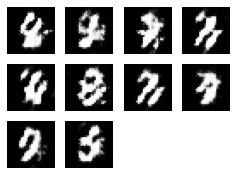

Time for epoch 5 is 7.7275309562683105 sec
Time for epoch 6 is 7.450619697570801 sec
Time for epoch 7 is 8.021438121795654 sec
Time for epoch 8 is 7.596571445465088 sec
Time for epoch 9 is 7.584576606750488 sec


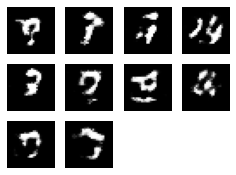

Time for epoch 10 is 8.234371423721313 sec
Time for epoch 11 is 8.172386169433594 sec
Time for epoch 12 is 7.59257435798645 sec
Time for epoch 13 is 7.704538345336914 sec
Time for epoch 14 is 7.4166295528411865 sec


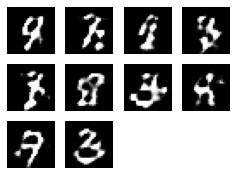

Time for epoch 15 is 7.723532676696777 sec
Time for epoch 16 is 7.443621873855591 sec
Time for epoch 17 is 7.693541526794434 sec
Time for epoch 18 is 7.859489917755127 sec
Time for epoch 19 is 8.076417684555054 sec


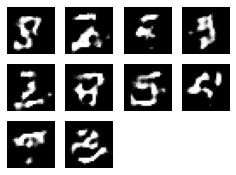

Time for epoch 20 is 7.871485948562622 sec
Time for epoch 21 is 7.8264992237091064 sec
Time for epoch 22 is 7.638558387756348 sec
Time for epoch 23 is 7.872485876083374 sec
Time for epoch 24 is 7.835495948791504 sec


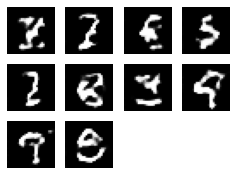

Time for epoch 25 is 7.819501161575317 sec
Time for epoch 26 is 7.880481243133545 sec
Time for epoch 27 is 8.129404544830322 sec
Time for epoch 28 is 7.677544832229614 sec
Time for epoch 29 is 7.744525671005249 sec


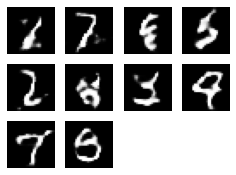

Time for epoch 30 is 7.792510032653809 sec
Time for epoch 31 is 7.425628900527954 sec
Time for epoch 32 is 7.635558605194092 sec
Time for epoch 33 is 7.563583850860596 sec
Time for epoch 34 is 7.7355287075042725 sec


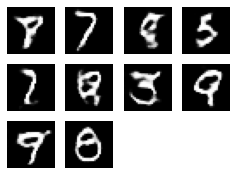

Time for epoch 35 is 7.806504726409912 sec
Time for epoch 36 is 7.528594970703125 sec
Time for epoch 37 is 7.6025710105896 sec
Time for epoch 38 is 7.967453479766846 sec
Time for epoch 39 is 7.507601976394653 sec


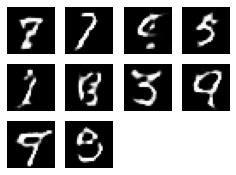

Time for epoch 40 is 7.685545206069946 sec
Time for epoch 41 is 7.4726104736328125 sec
Time for epoch 42 is 7.690542936325073 sec
Time for epoch 43 is 7.492605924606323 sec
Time for epoch 44 is 7.5046021938323975 sec


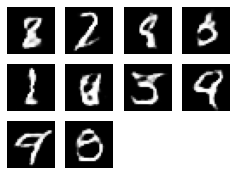

Time for epoch 45 is 7.568581819534302 sec
Time for epoch 46 is 7.573580741882324 sec
Time for epoch 47 is 7.510599374771118 sec
Time for epoch 48 is 7.480609893798828 sec
Time for epoch 49 is 7.593573331832886 sec


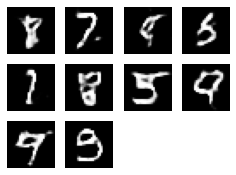

Time for epoch 50 is 8.257362365722656 sec


In [36]:
VISUALIZE_EVERY_X_EPOCHS = 5
CHECKPOINT_EVERY_X_EPOCHS = 10
EPOCHS = 50
train(awesome_train_dataset, EPOCHS)

The task rather proves difficult. With some imagination some of the results could indicate that the generator is able to learn that the additional written number input influences the generated image. The fake images created for the numbers 1,3 and 9 already look quite promising, even the numbers 5,6,7 and 8 are not too far from their intended outcome and indicate a learning success.
But this conclusion reveals to be a fallacy (check the stability test section).

Restore the latest checkpoint.

In [37]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

Use `imageio` to create an animated gif using the images saved during training.

In [38]:
anim_file = f"{output_dir}/dcgan.gif"

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(f"{output_dir}/image*.png")
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\Tom\AppData\Local\Temp\ipykernel_23372\254506623.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Tom\AppData\Local\Temp\ipykernel_23372\254506623.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



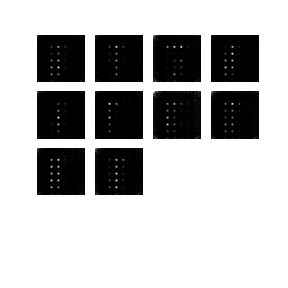

In [39]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Check the stability of the generator.

The previously shown results indicated that the generator was able to learn the correlation between the written number input and the generated image.
Sadly the stability test can't confirm that. Tests with different input noise vectors but same written number inputs lead to random outputs.

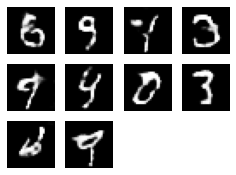

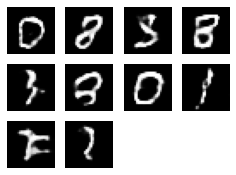

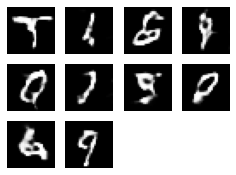

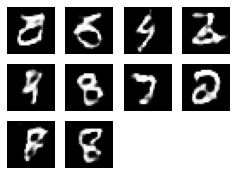

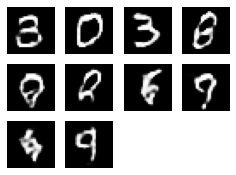

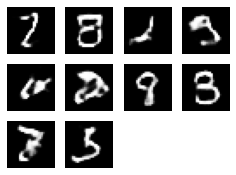

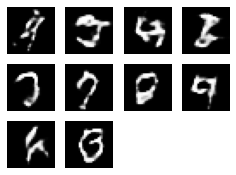

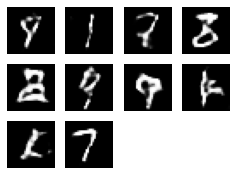

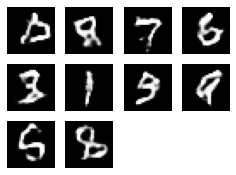

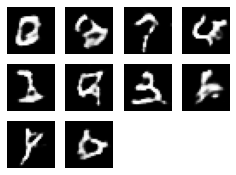

In [40]:
stability_test_dir = f"{output_dir}/stability-test"
os.makedirs(stability_test_dir, exist_ok=True)
for i in range(10):
    noise = tf.random.normal([num_examples_to_generate, noise_dim])
    generate_and_save_images(generator, noise, f"{stability_test_dir}/{i}.png", show=True)

## Conclusion

The code is a good groundwork to further experiment with text-to-image synthesis. As a difference to most other open source projects related to text-to-image synthesis, it uses the most recent version of Tensorflow. It can be executed on GPUs in case you have the proper CUDA and cuDNN prerequisites in place. Unfortunately the results are not as expected. The obvious assumption is that the text input is not decisive enough - it needs to be strengthened to receive a higher impact on the actual image generation.